Menggunakan PyTorch CNN
Device: cpu

--- Memuat Dataset MNIST ---
Training: (48000, 1, 28, 28)
Validation: (12000, 1, 28, 28)
Testing: (10000, 1, 28, 28)

--- Training CNN ---
Epoch 1/10 acc=0.9194 val_acc=0.9648
Epoch 2/10 acc=0.9793 val_acc=0.9822
Epoch 3/10 acc=0.9866 val_acc=0.9828
Epoch 4/10 acc=0.9890 val_acc=0.9858
Epoch 5/10 acc=0.9915 val_acc=0.9881
Epoch 6/10 acc=0.9939 val_acc=0.9838
Epoch 7/10 acc=0.9948 val_acc=0.9889
Epoch 8/10 acc=0.9950 val_acc=0.9868
Epoch 9/10 acc=0.9958 val_acc=0.9890
Epoch 10/10 acc=0.9965 val_acc=0.9850

--- Evaluasi Test ---
Test Accuracy: 0.9869
Test Loss: 0.04641528835260332

--- Saving Model ---
✓ Saved: models/mnist_cnn.pt


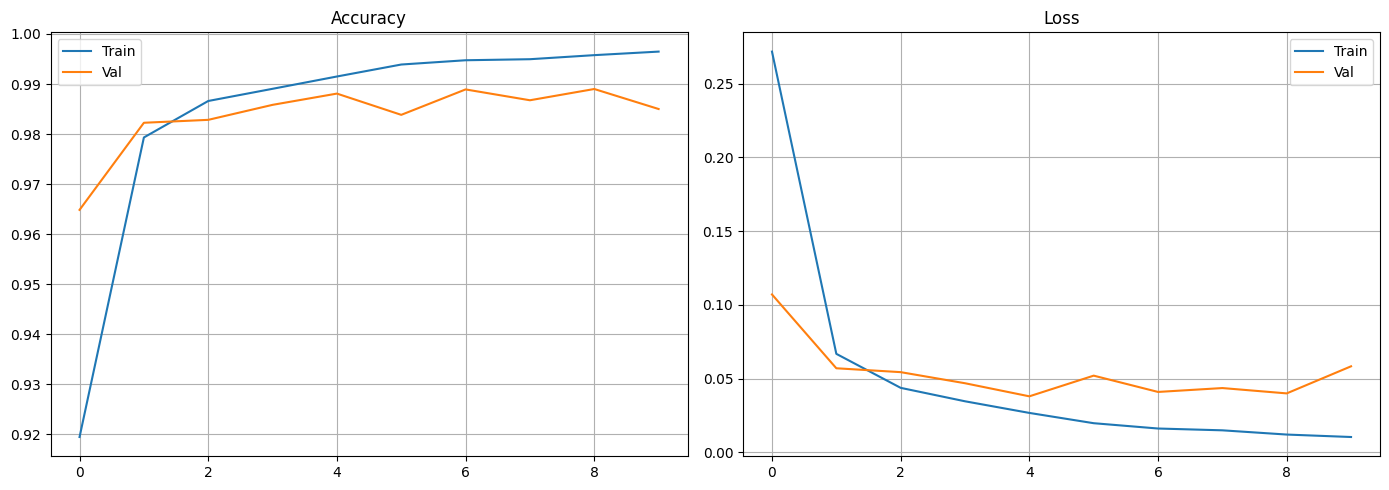

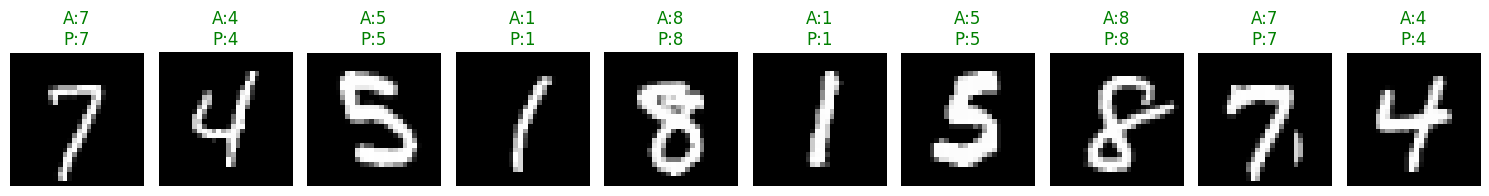


RINGKASAN
✓ Epoch: 10
✓ Best Val Acc: 0.989
✓ Test Acc: 0.9869
✓ Model: models/mnist_cnn.pt


In [1]:
# =====================================================
# IMPORT LIBRARIES
# =====================================================
import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

print("Menggunakan PyTorch CNN")

# =====================================================
# DEVICE
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =====================================================
# LOAD MNIST
# =====================================================
print("\n--- Memuat Dataset MNIST ---")

mnist = fetch_openml("mnist_784", version=1, as_frame=False)

X = mnist.data.astype("float32") / 255.0
y = mnist.target.astype("int64")

# Reshape → CNN format
X = X.reshape(-1, 1, 28, 28)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y
)

x_tr, x_val, y_tr, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print("Training:", x_tr.shape)
print("Validation:", x_val.shape)
print("Testing:", x_test.shape)

# =====================================================
# DATALOADERS
# =====================================================
batch_size = 128

train_loader = DataLoader(
    TensorDataset(torch.tensor(x_tr), torch.tensor(y_tr)),
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    TensorDataset(torch.tensor(x_val), torch.tensor(y_val)), batch_size=batch_size
)

test_loader = DataLoader(
    TensorDataset(torch.tensor(x_test), torch.tensor(y_test)), batch_size=batch_size
)


# =====================================================
# CNN MODEL
# =====================================================
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(), nn.Linear(64 * 7 * 7, 128), nn.ReLU(), nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


model = MNIST_CNN().to(device)

# =====================================================
# LOSS + OPTIMIZER
# =====================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

# =====================================================
# TRAINING LOOP
# =====================================================
print("\n--- Training CNN ---")

history_acc = []
history_val_acc = []
history_loss = []
history_val_loss = []

best_val_acc = 0
best_model = deepcopy(model)

for epoch in range(epochs):

    # -------- TRAIN --------
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = outputs.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total
    train_loss /= len(train_loader)

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)

            outputs = model(Xb)
            loss = criterion(outputs, yb)

            val_loss += loss.item()

            preds = outputs.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    val_acc = correct / total
    val_loss /= len(val_loader)

    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = deepcopy(model)

    history_acc.append(train_acc)
    history_val_acc.append(val_acc)
    history_loss.append(train_loss)
    history_val_loss.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} " f"acc={train_acc:.4f} " f"val_acc={val_acc:.4f}")

# =====================================================
# TEST EVALUATION
# =====================================================
print("\n--- Evaluasi Test ---")

model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)

        outputs = model(Xb)
        probs = torch.softmax(outputs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_preds.append(outputs.argmax(1).cpu().numpy())
        all_labels.append(yb.numpy())

all_preds = np.concatenate(all_preds)
all_probs = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)

test_acc = accuracy_score(all_labels, all_preds)
test_loss = log_loss(all_labels, all_probs)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

# =====================================================
# SAVE MODEL
# =====================================================
print("\n--- Saving Model ---")

os.makedirs("models", exist_ok=True)

torch.save(best_model.state_dict(), "models/mnist_cnn.pt")
print("✓ Saved: models/mnist_cnn.pt")

# =====================================================
# TRAINING PLOTS
# =====================================================
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_acc, label="Train")
plt.plot(history_val_acc, label="Val")
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_loss, label="Train")
plt.plot(history_val_loss, label="Val")
plt.title("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig("models/training_history_cnn.png")
plt.show()

# =====================================================
# VISUALIZE PREDICTIONS
# =====================================================
plt.figure(figsize=(15, 3))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_test[i][0], cmap="gray")

    color = "green" if all_preds[i] == y_test[i] else "red"
    plt.title(f"A:{y_test[i]}\nP:{all_preds[i]}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.savefig("models/predictions_cnn.png")
plt.show()

# =====================================================
# SUMMARY
# =====================================================
print("\n" + "=" * 50)
print("RINGKASAN")
print("=" * 50)
print("✓ Epoch:", epochs)
print("✓ Best Val Acc:", best_val_acc)
print("✓ Test Acc:", test_acc)
print("✓ Model: models/mnist_cnn.pt")
print("=" * 50)